In [1]:
!pip install -q kaggle

Go to your Kaggle account settings, create a new token (kaggle.json), and upload this to Colab before running the cell below.

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d yasserh/imdb-movie-ratings-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis
License(s): CC0-1.0
100% 20.6M/20.6M [00:02<00:00, 11.7MB/s]
100% 20.6M/20.6M [00:02<00:00, 8.10MB/s]


In [4]:
!unzip -q /content/imdb-movie-ratings-sentiment-analysis.zip

In [5]:
!pip install nltk

In [6]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.5 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import contractions
import pandas as pd
import re
import nltk
import contractions
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Bidirectional
from keras.layers import Embedding
from keras.layers import LSTM

In [8]:
df = pd.read_csv('movie.csv')
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
df['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

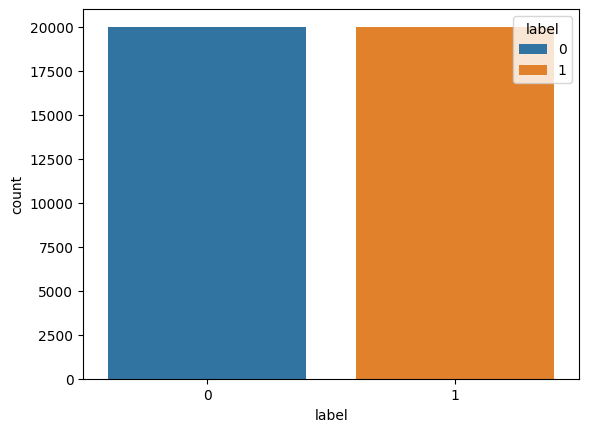

In [ ]:
sns.countplot(data=df, x=df['label'], hue=df['label'])

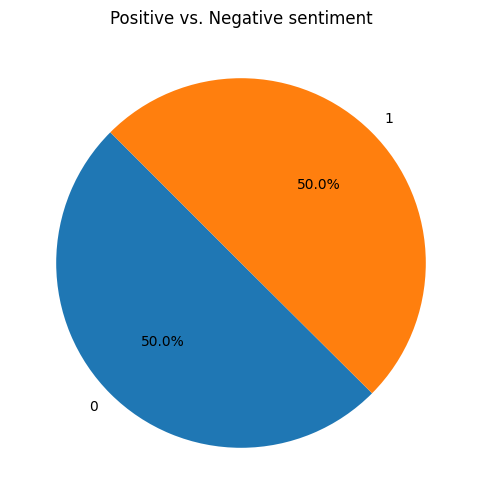

In [ ]:
sentiments = df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(
  sentiments,
  labels=sentiments.index,
  autopct='%1.1f%%',
  startangle=135
  )
plt.title('Positive vs. Negative sentiment')
plt.show()

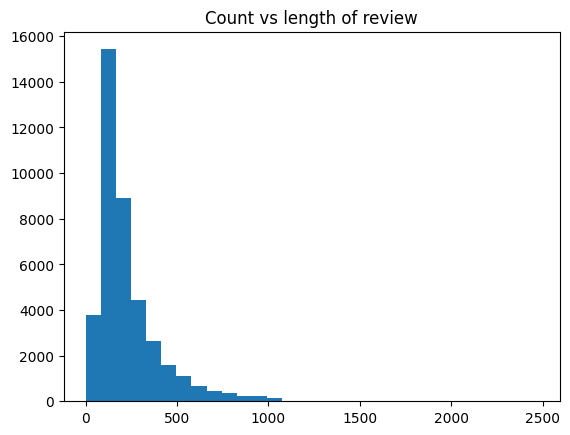

In [ ]:
word_counts = df['text'].apply(lambda x: len(x.split()))
plt.hist(word_counts, bins=30)
plt.title("Count vs length of review")
plt.show()

In [ ]:
df.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [9]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

277
0


In [ ]:
df.sample(50)

,text,label
2014,This film was pretty good. I am not too big a ...,1
17906,me and my sister use to rent this every time w...,1
28343,I absolutely love this game to death. Ever sin...,1
6092,"I have seen this movie a while back, after ord...",1
10278,I got a chance to see this movie at an early s...,1
4321,Zoey 101 is such a stupid show. I don't know i...,0
20979,This ABC straight-to-TV failure does absolutel...,0
7635,"Charleton Heston wore one, James Franciscus wo...",1
14247,"Combine good casting, bad writing, good orches...",0
8182,Comparison with American Graffiti is inevitabl...,0


In [10]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):

    # for changing doesnt to does not etc
    text = contractions.fix(text)

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # remove urls
    text = re.sub(r'<.*?>', '', text) # remove html tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    words = text.split()

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Lemmatize the remaining words
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)
    # return words

In [ ]:
print('Before')
print('Text: ', df['text'][500], '\nLabel: ', df['label'][500], '\n')

Before
Text:  Just because an event really happened doesn't mean that it will make a good screenplay/ movie. The Cat's Meow, by Peter Bogdanovich claims to be based on actual events which happened on a cruise hosted by William Randolph Hurst. The writer paid more attention to creating a bizarre cast of characters than taking time to create a story for the bizarre characters to inhabit. The key moments of the story seem implausible; for example, when Hurst accidentally shoots the producer, believing him to be Chaplin. Basing a key element of a story on someone wearing the wrong hat is trite and contrived. The story attempts to be a dark comedy, but The Cat's Meow misses an important piece of this equation, comedy. There is also a lack of empathy for any of the characters. It hardly matters who is shot, who is killed, who is guilty and who is innocent. There is not a strong character to cheer for. As a result the conflicts are difficult to care about and the eventual outcome is incidenta

In [12]:
df['text'] = df['text'].apply(preprocess_text)

print('After')
print('Text: ', df['text'][500], '\nLabel: ', df['label'][500], '\n')

After
Text:  event really happened mean make good screenplay movie cat meow peter bogdanovich claim based actual event happened cruise hosted william randolph hurst writer paid attention creating bizarre cast character taking time create story bizarre character inhabit key moment story seem implausible example hurst accidentally shoot producer believing chaplin basing key element story someone wearing wrong hat trite contrived story attempt dark comedy cat meow miss important piece equation comedy also lack empathy character hardly matter shot killed guilty innocent strong character cheer result conflict difficult care eventual outcome incidental 
Label:  0 



In [ ]:
df.sample(50)

,text,label
34849,minor quibble film grew knowing stairway heave...,1
10842,one decent sceneamy adam give one worst perfor...,0
5692,movie incredibly realistic feel great justice ...,1
10945,working way horror classic movie pack collecti...,0
32016,simply awful including spoiler warning includi...,0
30630,feeling mislike russian film seeing film haven...,1
28812,ben rupert grint deeply unhappy adolescent son...,0
15195,great cast jonathan pryce kathy bates rupert e...,1
22227,terrible like somebody gave kid faulty video c...,0
33088,excellent movie great example scary movie with...,1


In [ ]:
print(df['text'][26968])
print(df['text'][30763])

one best film ever seen robert duvalls performance excellent outstanding wonderful job making character really come life character convincing made almost think theater watching live give star
please waste hour life watching movie especially someone fortunate snoozing side damn cheek ask waited something happen never one people stop watching movie part way always see end huge mistake favour go paint wall watch dry far entertaining please waste hour life watching movie especially someone fortunate snoozing side damn cheek ask waited something happen never one people stop watching movie part way always see end huge mistake favour go paint wall watch dry far entertaining


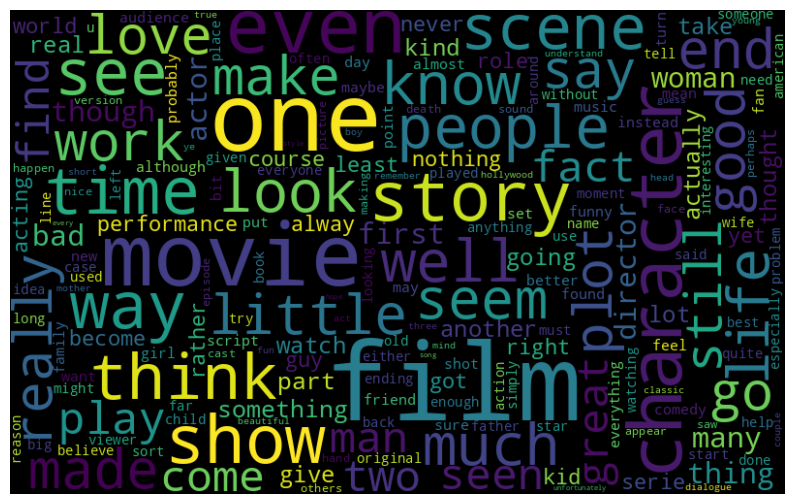

In [ ]:
all_words = ' '.join([text for text in df['text']])

from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**LSTM** **WORD2VEC**


In [ ]:
sentences = df['text'].tolist()

# Tokenizing the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences) # will break down the reviews into individual words
sequences = tokenizer.texts_to_sequences(sentences) # convert sentences to sequence (numbers)
word_index = tokenizer.word_index # each token will have an id starting from 1, dict of mapping word to id
print("word index: ", len(word_index)) # the num of unique tokens

word index:  174927


(array([2.9927e+04, 7.4350e+03, 1.7640e+03, 5.6600e+02, 2.1000e+01,
        3.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   3. ,  143.5,  284. ,  424.5,  565. ,  705.5,  846. ,  986.5,
        1127. , 1267.5, 1408. ]),
 <BarContainer object of 10 artists>)

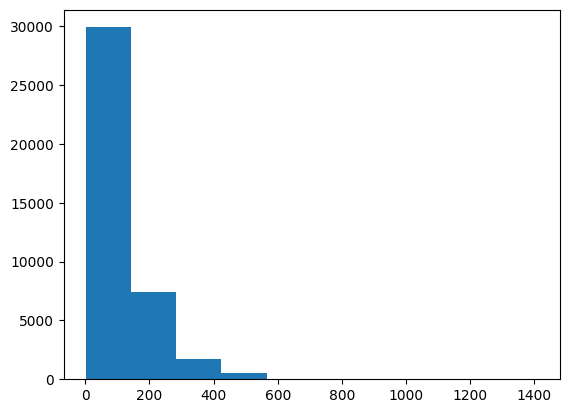

In [ ]:
train_lens = [len(i.split()) for i in sentences]
plt.hist(train_lens)

In [ ]:
max_length = 200
data = pad_sequences(sequences, maxlen=max_length) # all reviews should be of same length for model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, df['label'], test_size=0.2, random_state=42)

In [ ]:
tokenized_text = df['text'].apply(lambda x: x.split()) # tokenizing for word2vec
word2vec_model = Word2Vec(tokenized_text) # vector size: num of dim of embedding default:100, window: max distance b/w target word and words around target default:5, min count: min num of words to consider, words less than this are ignored default:5, workers: num of partitions during training default:3, sg: 0(CBOW) 1(SKIP GRAM) 0 is default

In [ ]:
words = list(word2vec_model.wv.index_to_key)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 34410


In [ ]:
word2vec_model.wv.most_similar('awesome')

[('fantastic', 0.7516886591911316),
 ('cool', 0.7165645956993103),
 ('amazing', 0.6986533999443054),
 ('spectacular', 0.6575549840927124),
 ('great', 0.6514294743537903),
 ('incredible', 0.6169044971466064),
 ('excellent', 0.5977239608764648),
 ('liked', 0.5961141586303711),
 ('good', 0.578031063079834),
 ('wonderful', 0.5744565725326538)]

In [ ]:
word2vec_model.wv.doesnt_match('woman king queen movie'.split())

'movie'

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
print("vocab size:", vocab_size)
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items(): # for each word in my tokenized reviews
    if word in word2vec_model.wv: # if the word is in the trained vocab
        embedding_matrix[i] = word2vec_model.wv[word] # get its feature vector and add to the embedding matrix


vocab size: 174928


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.003,  # Your initial learning rate
#     decay=1e-6,  # Learning rate decay parameter
#     beta_1=0.9,  # Exponential decay rate for the first moment estimates
#     beta_2=0.999,  # Exponential decay rate for the second moment estimates
#     epsilon=1e-08,  # A small constant for numerical stability
#     # Add regularization if needed
#     # regularizer=regularizers.l2(0.01)  # Example of L2 regularization
# )


model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)) # embedding layer not trainable as we have the trained model with the matrix
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(128)))
# model.add(LSTM(128))
model.add(Dense(64))
model.add(Dropout(0.4))
model.add(Activation('relu'))
model.add(Dense(1)) # single unit for binary classification
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          17492800  
                                                                 
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 activation (Activation)     (None, 64)                0         
                                                        

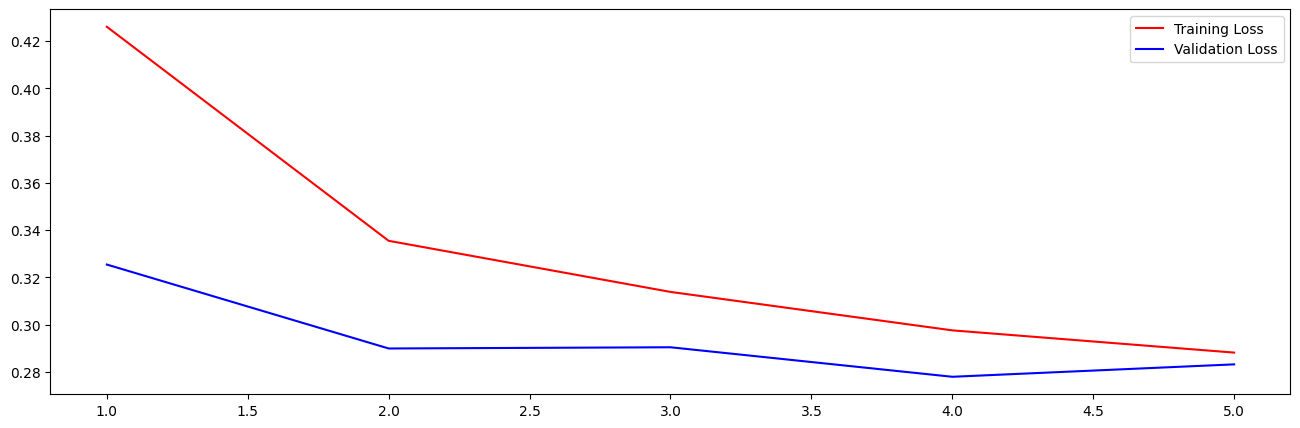

In [ ]:
plt.figure(figsize= (16,5))
epochs = range(1, len(history.history['loss'])+1)
plt.plot(epochs, history.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

249/249 [==============================] - 2s 8ms/step - loss: 0.2926 - accuracy: 0.8834
Test Loss: 0.2925584018230438
Test Accuracy: 0.8834487199783325


**END OF LSTM WORD2VEC**

**CNN WITH WORD2VEC**

In [ ]:
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.optimizers import Adam
import tensorflow as tf

kernel_size = 3
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Dropout(0.4))
model.add(Conv1D(64, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.4))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1, shuffle=True)

Epoch 1/5
447/447 [==============================] - 37s 77ms/step - loss: 0.4944 - accuracy: 0.7363 - val_loss: 0.3279 - val_accuracy: 0.8549
Epoch 2/5
447/447 [==============================] - 24s 54ms/step - loss: 0.3912 - accuracy: 0.8286 - val_loss: 0.3337 - val_accuracy: 0.8556
Epoch 3/5
447/447 [==============================] - 24s 54ms/step - loss: 0.3694 - accuracy: 0.8437 - val_loss: 0.3106 - val_accuracy: 0.8663
Epoch 4/5
447/447 [==============================] - 22s 50ms/step - loss: 0.3499 - accuracy: 0.8514 - val_loss: 0.3215 - val_accuracy: 0.8638
Epoch 5/5
447/447 [==============================] - 26s 57ms/step - loss: 0.3352 - accuracy: 0.8560 - val_loss: 0.3127 - val_accuracy: 0.8656


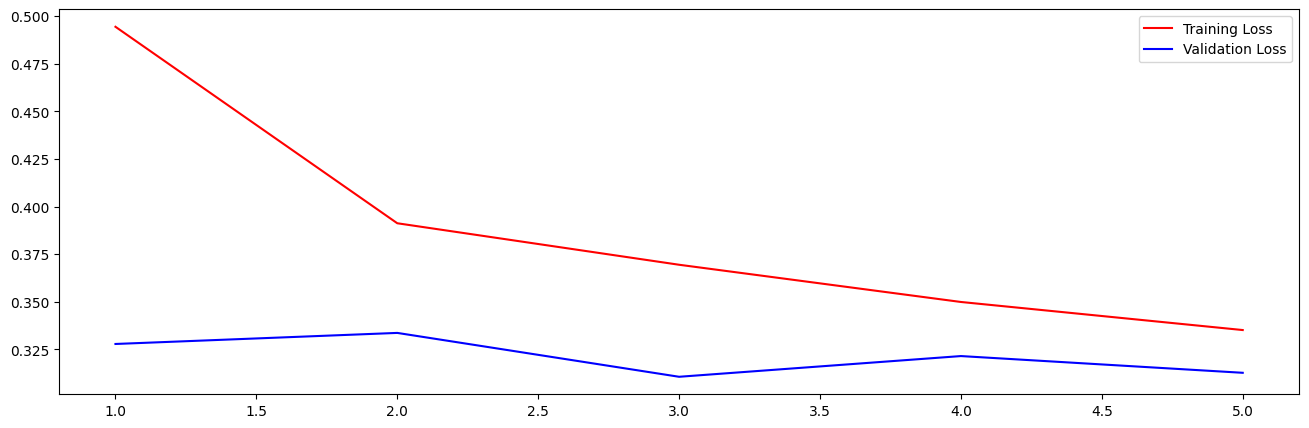

In [ ]:
plt.figure(figsize= (16,5))
epochs = range(1, len(history.history['loss'])+1)
plt.plot(epochs, history.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

249/249 [==============================] - 2s 8ms/step - loss: 0.3199 - accuracy: 0.8670
Test Loss: 0.31994861364364624
Test Accuracy: 0.866960346698761


**END OF CNN WITH WORD2VEC**

**BERT fine tuning**

In [13]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [14]:
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state = 42,
                                                                    test_size = 0.3,
                                                                    stratify = df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state = 42,
                                                                test_size = 0.5,
                                                                stratify = temp_labels)

In [15]:
#for pytorch
import torch
import torch.nn as nn
device = torch.device("cuda")

#for BERT
import transformers
from transformers import AutoModel, BertTokenizerFast

In [16]:
#load model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(array([2.0926e+04, 5.2070e+03, 1.2420e+03, 4.1000e+02, 1.4000e+01,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   3. ,  143.5,  284. ,  424.5,  565. ,  705.5,  846. ,  986.5,
        1127. , 1267.5, 1408. ]),
 <BarContainer object of 10 artists>)

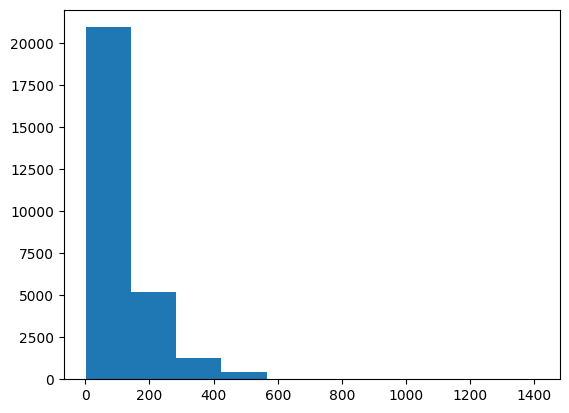

In [17]:
train_lens = [len(i.split()) for i in train_text]
plt.hist(train_lens)

In [18]:
# tokenize and encode sequences
pad_len=200

tokens_train = tokenizer.batch_encode_plus(
	train_text.tolist(),
	max_length = pad_len,
	pad_to_max_length = True,
	truncation = True
)

tokens_val = tokenizer.batch_encode_plus(
	val_text.tolist(),
	max_length = pad_len,
	pad_to_max_length = True,
	truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
	test_text.tolist(),
	max_length = pad_len,
	pad_to_max_length = True,
	truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [20]:
class BERT_architecture(nn.Module):

    def __init__(self, bert):

      super(BERT_architecture, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.2)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [27]:
# pass the pre-trained BERT to our define architecture
model = BERT_architecture(bert)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# push the model to GPU
model = model.to(device)

In [28]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)  # learning rate

In [29]:
# define loss function
cross_entropy  = nn.NLLLoss()

# number of training epochs
epochs = 3

In [30]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [31]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [32]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))


 Epoch 1 / 3
  Batch    50  of    435.
  Batch   100  of    435.
  Batch   150  of    435.
  Batch   200  of    435.
  Batch   250  of    435.
  Batch   300  of    435.
  Batch   350  of    435.
  Batch   400  of    435.

Evaluating...
  Batch    50  of     94.

Training Loss: 0.38574588696161904
Validation Loss: 0.2810074780532654

 Epoch 2 / 3
  Batch    50  of    435.
  Batch   100  of    435.
  Batch   150  of    435.
  Batch   200  of    435.
  Batch   250  of    435.
  Batch   300  of    435.
  Batch   350  of    435.
  Batch   400  of    435.

Evaluating...
  Batch    50  of     94.

Training Loss: 0.25371893135638074
Validation Loss: 0.271225280742696

 Epoch 3 / 3
  Batch    50  of    435.
  Batch   100  of    435.
  Batch   150  of    435.
  Batch   200  of    435.
  Batch   250  of    435.
  Batch   300  of    435.
  Batch   350  of    435.
  Batch   400  of    435.

Evaluating...
  Batch    50  of     94.

Training Loss: 0.19926222725503745
Validation Loss: 0.2535657919150

In [34]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Create a DataLoader for test data
test_data = TensorDataset(test_seq, test_mask, test_y)
test_loader = DataLoader(test_data, batch_size=64)  # Adjust batch_size according to your memory limits

# Load the best model weights
path = '/content/saved_weights.pt'
model.load_state_dict(torch.load(path))

# Ensure model is in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_true = []

# Evaluate the model in batches
with torch.no_grad():
    for batch in test_loader:
        batch_seq, batch_mask, batch_y = batch
        batch_seq = batch_seq.to(device)
        batch_mask = batch_mask.to(device)

        # Get model predictions
        preds = model(batch_seq, batch_mask)

        # Move predictions to CPU and store
        preds = preds.detach().cpu().numpy()
        all_preds.extend(np.argmax(preds, axis=1))
        all_true.extend(batch_y.numpy())

# Print classification report
print(classification_report(all_true, all_preds))


              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2973
           1       0.88      0.91      0.90      2986

    accuracy                           0.89      5959
   macro avg       0.89      0.89      0.89      5959
weighted avg       0.89      0.89      0.89      5959



**ML ALGS**

**TF-IDF**

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['label'], test_size=0.2, random_state=0, stratify=df['label'])

**Linear SVC**

In [ ]:
svm_classifier = LinearSVC(loss='hinge',random_state=0)

In [ ]:
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3963
           1       0.89      0.91      0.90      3982

    accuracy                           0.90      7945
   macro avg       0.90      0.90      0.90      7945
weighted avg       0.90      0.90      0.90      7945



TF-IDF LINEAR SVC BASE: 0.89

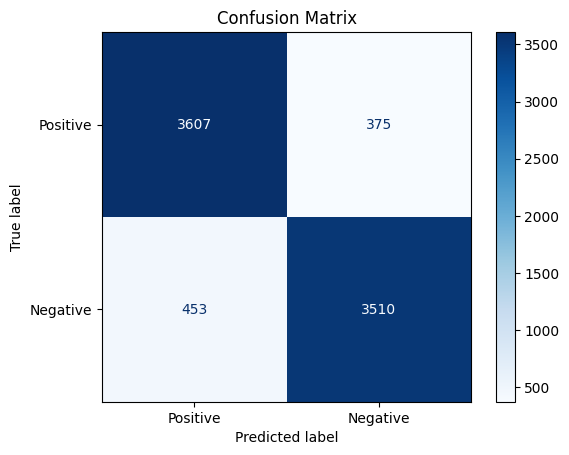

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues, values_format='d')  # Use 'd' to show integer counts
plt.title('Confusion Matrix')
plt.show()

ROC AUC Score: 0.96


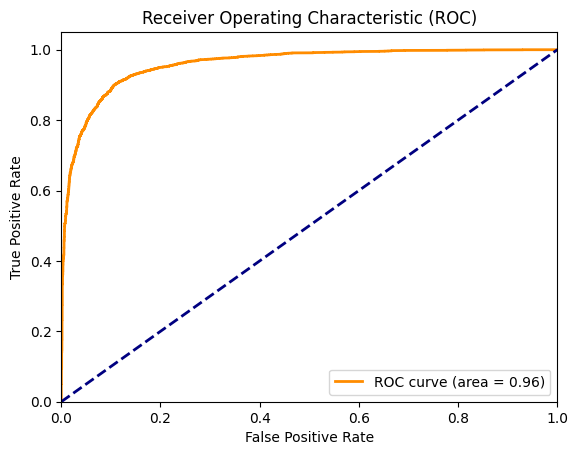

In [ ]:
# Get decision function scores (y_scores)
y_scores = svm_classifier.decision_function(X_test)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_scores)
print(f'ROC AUC Score: {roc_auc:.2f}')

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
# Initialize Logistic Regression classifier
logreg_classifier = LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
# Train the model
logreg_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_logreg = logreg_classifier.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy: {accuracy_logreg:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3963
           1       0.88      0.91      0.89      3982

    accuracy                           0.89      7945
   macro avg       0.89      0.89      0.89      7945
weighted avg       0.89      0.89      0.89      7945



TF-IDF LOGISTIC REGRESSION BASE: 0.89

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

**Multinomial Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# Initialize Naive Bayes classifier
nb_classifier = MultinomialNB(alpha=1.5)

In [ ]:
# Train the model
nb_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_nb = nb_classifier.predict(X_test)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {accuracy_nb:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3963
           1       0.87      0.87      0.87      3982

    accuracy                           0.87      7945
   macro avg       0.87      0.87      0.87      7945
weighted avg       0.87      0.87      0.87      7945



In [ ]:
# from scipy.stats import mode

# # Majority voting
# final_preds, _ = mode([y_pred, y_pred_logreg, y_pred_nb], axis=0)
# final_preds = final_preds.ravel()

In [ ]:
# from sklearn.metrics import accuracy_score

# # Evaluate
# accuracy = accuracy_score(y_test, final_preds)
# print(f'Ensemble Accuracy: {accuracy}')

TF-IDF MNB BASE: 0.86

**XGBoost**

In [ ]:
from xgboost import XGBClassifier
# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(n_estimators=500,random_state=0, max_depth=5)

In [ ]:
# Train the model
xgb_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy_xgb:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      3963
           1       0.86      0.88      0.87      3982

    accuracy                           0.87      7945
   macro avg       0.87      0.87      0.87      7945
weighted avg       0.87      0.87      0.87      7945



TF-IDF XGBOOST BASE: 0.85

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_features='sqrt', # Number of features to consider when looking for the best split
    random_state=0
)

In [ ]:
# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3963
           1       0.85      0.87      0.86      3982

    accuracy                           0.86      7945
   macro avg       0.86      0.86      0.86      7945
weighted avg       0.86      0.86      0.86      7945



TF-IDF RANDOM FOREST BASE: 0.84

In [ ]:
from sklearn.ensemble import VotingClassifier

# Example with hard voting
voting_clf = VotingClassifier(
    estimators=[('lr', logreg_classifier),
                ('rf', rf_classifier),
                ('nb', nb_classifier),
                ('xgb', xgb_classifier),
                ('svc', svm_classifier)],
    voting='hard')
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=0,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=0)),
                             ('nb', MultinomialNB(alpha=1.5)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=0, ...)),
                             ('svc', LinearSVC(loss='hinge', random_state=0))])

In [ ]:
# Predict on test data
y_pred_v = voting_clf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_v)

In [ ]:
accuracy_rf

0.8935179358086847